# Costa Rican Household Poverty Level Prediction 




## Primary Objective
<br>
The target of our analysis would be to predict poverty on a household level as defined in the dataset. Given that dataset is on an individual level in terms of the datapoints, however we will only include the head of the household to stick with our plan of conducting the analysis on a household basis. The following would be the target variable values: 

1 = extreme poverty <br>
2 = moderate poverty <br>
3 = vulnerable households <br> 
4 = non vulnerable households <br>
<br>

## Special Features 
<br>
Out of the 143 features, following features will be treated little differently in our analysis:
<br>
*Id*: a unique identifier for each individual, this should not be a feature that we use!<br>
<br>
*idhogar*: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.<br>
<br>
*parentesco1*: indicates if this person is the head of the household.<br>
<br>
*Target*: the label, which should be equal for all members in a household <br>
<br>


## Scoring Metric
<br>
Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the Macro F1 Score.
<br>

## Secondary Objective
<br>
1. Feature Engineering <br>
2. Select a model by comparison <br>
3. Optimise the choice for the model <br>
4. Understand the outputs of the model <br>
5. Draw insights and breakdown the analysis and prediction <br>
<br>

## Data Cleansing 
<br>

Let's first go through our dataset and look for errors and missing values and see how we can fix it in this section.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

test['Target'] = np.nan
data = train.append(test, ignore_index = True)

# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

In [3]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16,NaN
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681,NaN
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681,NaN
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481,NaN
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324,NaN


In [4]:
unique_values = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
different_households = unique_values[unique_values != True]
print('There are {} households where the family members do not all have the same target.'.format(len(different_households)))

There are 85 households where the family members do not all have the same target.


In [5]:
train[train['idhogar'] == different_households.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


As described in the initial background, we concluded that we would analyse the head of each household to predict which poverty level the household belongs in (i.e. parentesco = 1). So here members of the same households would belong to the same target variables which is 3 in our case.

### Families without a head of the household

Now let's check the families that don't have a head in our dataset

In [6]:
check_leader = train.groupby('idhogar')['parentesco1'].sum()

#Check for head
no_head = train.loc[train['idhogar'].isin(check_leader[check_leader == 0].index), :]
print('There are {} households without a head.'.format(no_head['idhogar'].nunique()))

There are 15 households without a head.


And check for households with no heads but have different labels.

In [7]:
no_head_equal = no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(no_head_equal == False)))

0 Households with no head have different labels.


Meaning that there is no household which has no head and the family members have different labels. 

### Applying Correct Labels

So given that we identified households which do not have a head however their family members have the same label. SO let's fix it by making sure that every family member in the same family has a common target variable.  

In [8]:
for each_household in different_households.index:
    
    #find the correct label
    true_target = int(train[(train['idhogar'] == each_household) & (train['parentesco1'] == 1.0)]['Target'])
    
    #assign the correct label for each member
    train.loc[train['idhogar'] == each_household, 'Target'] = true_target

unique_values = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
different_households = unique_values[unique_values != True]
print('There are {} households where the family members do not all have the same target.'.format(len(different_households)))

There are 0 households where the family members do not all have the same target.


### Finding Feaures with Missing Values and filling them up

Now we need to carefully go through each variable and see how we can replace the missing values with the values we want to fill.

In [9]:
missing_variables = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})
missing_variables['percent'] = missing_variables['total']/len(data)
missing_variables.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


Let's start with fillinf missing values in v2a1 which is essentially the Number of Tablets in a households

In [10]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Now all the families that do not own a tablet have a NaN as value. So we can assign this NaN as 0 instead!

In [11]:
data['v18q1'] = data['v18q1'].fillna(0)

Second, we got v2a1 which is Monthly Rent Payment. We have following categorical variable values:

tipovivi1, =1 own and fully paid house <br>
tipovivi2, "=1 own,  paying in installments" <br>
tipovivi3, =1 rented <br>
tipovivi4, =1 precarious <br>
tipovivi5, "=1 other(assigned,  borrowed)" <br>
<br>

So now for the households that owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [12]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()


False    29994
True      3419
Name: v2a1-missing, dtype: int64

Now we can move to the next column which is **rez_esc**(years behind in school).<br>
<br>
So it maybe possible that certain datapoints with null value in this column could have the case of none of the family members having any schooling at all. Let's see what are the ages of the family members for which we have null values. 



In [13]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

We can learn that this variable is only defined for individuals between 7 and 19. Anyone older or younger might not have any years of schooling so this can be set to zero. For the rest we shall add a boolean flag.

In [14]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

#Setting the maximum value to 5
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

# Feature Engineering

There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need _all_ of the information summarized for each household. This means grouping the individuals in a house (`groupby`) and performing an aggregation (`agg`) of the individual variables. 

In another notebook, I show how we can use automated feature engineering to do this, and __automated feature engineering__ should be a standard part of the machine learning workflow. Right now, we'll stick to doing this by hand, but definitely take a look at __automated feature engineering in Featuretools__.

## Column Definitions

Sometimes in data science we have to get our hands dirty digging through the data or do tedious tasks that take a lot of time. This is that part of the analysis: we have to define the columns that are at an individual level and at a household level using the [data decsriptions](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data). There is simply no other way to identify which variables at are the household level than to go through the variables themselves in the data description. Except, I've already done this for you, so all you have to do is copy and paste!

We'll define different variables because we need to treat some of them in a different manner. Once we have the variables defined on each level, we can work to start aggregating them as needed.

The process is as follows

1. Break variables into household level and invididual level
2. Find suitable aggregations for the individual level data
    * Ordinal variables can use statistical aggregations
    * Boolean variables can also be aggregated but with fewer stats
3. Join the individual aggregations to the household level data

### Define Variable Categories

There are several different categories of variables:

1. Individual Variables: these are characteristics of each individual rather than the household
    * Boolean: Yes or No (0 or 1)
    * Ordered Discrete: Integers with an ordering
2. Household variables
    * Boolean: Yes or No
    * Ordered Discrete: Integers with an ordering
    * Continuous numeric
3. Squared Variables: derived from squaring variables in the data
4. Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary. 

In [15]:
id_ = ['Id', 'idhogar', 'Target']

In [16]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [17]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [18]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Let's make sure we covered all of the variables and didn't repeat any. 

In [19]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

('There are no repeats: ', True)
('We covered every variable: ', True)


#### Squared Variables

First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

For an example, let's take a look at `SQBage` vs `age`.

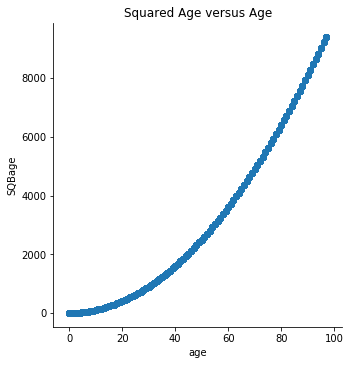

In [20]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

These variables are highly correlated, and we don't need to keep both in our data.

In [21]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

## Id Variables

These are pretty simple: they will be kept as is in the data since we need them for identification.

## Household Level Variables

First let's subset to the heads of household and then to the household level variables.

In [22]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

For most of the household level variables, we can simply keep them as is: since we want to make predictions for each household, we use these variables as features. However, we can also remove some redundant variables and also add in some more features derived from existing data. 

### Redundant Household Variables

Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.

The following code identifies any variables with a greater than 0.95 absolute magnitude correlation.

In [23]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

These show one out of each pair of correlated variables. To find the other pair, we can subset the `corr_matrix`. 

In [24]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


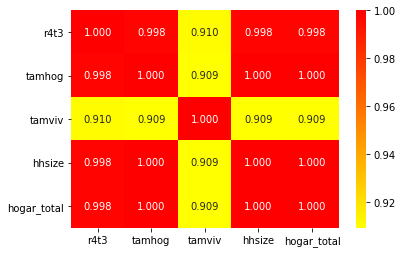

In [25]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

There are several variables here having to do with the size of the house:

* r4t3, Total persons in the household
* tamhog, size of the household
* tamviv, number of persons living in the household
* hhsize, household size
* hogar_total, # of total individuals in the household

These variables are all highly correlated with one another. In fact, `hhsize` has a perfect correlation with `tamhog` and `hogar_total`. We will remove these two variables because the information is redundant. We can also remove `r4t3` because it has a near perfect correlation with `hhsize`.

`tamviv` is not necessarily the same as `hhsize` because there might be family members that are not living in the household. Let's visualize this difference in a scatterplot.

In [26]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

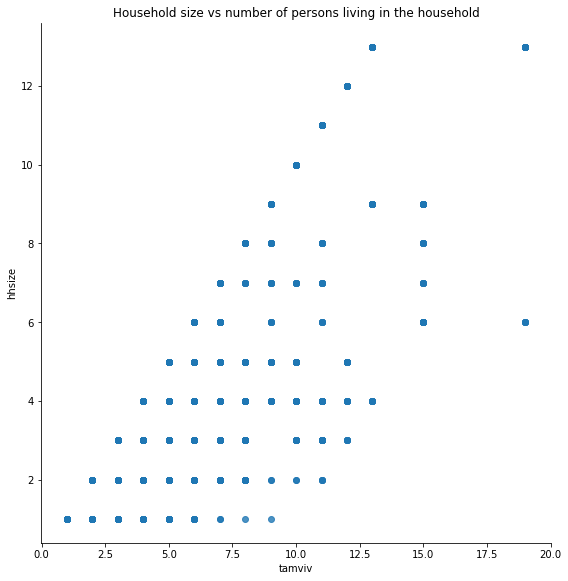

In [27]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: __the difference between these two measurements!__

Let's make this new feature.

In [28]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

Even though most households do not have a difference, there are a few that have more people living in the household than are members of the household.

Let's move on to the other redundant variables. First we can look at `coopele`

In [29]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


These variables indicate where the electricity in the home is coming from. There are four options, and the families that don't have one of these two options either have no electricity (`noelec`) or get it from a private plant (`planpri`). 

#### Creating Ordinal Variable

I'm going to compress these four variables into one by creating an ordinal variable. I'm going to choose the mapping myself, based on the data decriptions: 

    0: No electricity
    1: Electricity from cooperative
    2: Electricity from CNFL, ICA, ESPH/JASEC
    3: Electricity from private plant

An ordered variable has an inherent ordering, and for this we choose our own based on the domain knowledge. After we create this new ordered variable, we can drop the four others. There are several households that do not have a variable here, so we will use a `nan` (which will be filled in during imputation) and add a Boolean column indicating there was no measure for this variable.

In [30]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

We can see that for every value of the Target, the most common source of electricity is from one of the listed providers. 

The final redundant column is `area2`. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [31]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

### Creating Ordinal Variables

For the walls, roof, and floor of the house, there are three columns each: the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order: `bad < regular < good`. To do this, we can simply find whichever column is non-zero for each household using `np.argmax`. 

Once we have created the ordinal variable, we are able to drop the original variables.

In [32]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])

In [33]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

## Feature Construction

In addition to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the house's structure.

In [34]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']


This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. We can also look at this in a table to get the fine-grained details.

In [35]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


The next variable will be a `warning` about the quality of the house. It will be a negative value, with -1 point each for no toilet, electricity, floor, water service, and ceiling.

In [36]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

We can keep using our `plot_categoricals` function to visualize these relationships, but `seaborn` also has a number of plotting options that can work with categoricals. One is the `violinplot` which shows the distribution of a variable on the y axis with the width of each plot showing the number of observations in that category. 

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


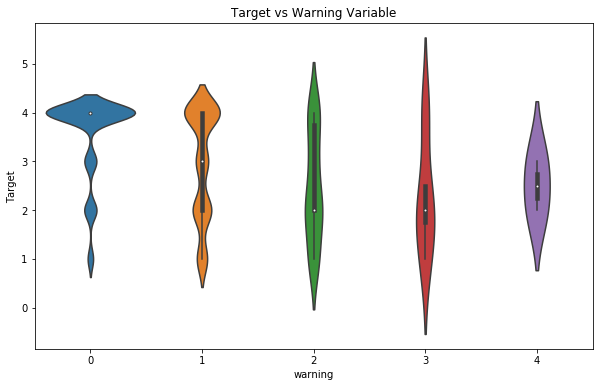

In [37]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Warning Variable');

The violinplot is not great here because it smooths out the categorical variable with the effect that it looks as if the Target can take on lesser and greater values than in reality. Nonetheless, we can see a high concentration of households that have no warning signs and have the lowest level of poverty. It looks as if this may be a useful feature, but we can't know for sure until we get to modeling!

The final household feature we can make for now is a `bonus` where a family gets a point for having a refrigerator, computer, tablet, or television.

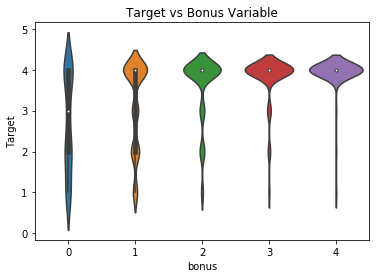

In [38]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

## Per Capita Features

Additional features we can make calculate the number of certain measurements for each person in the household.

In [39]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploring Household Variables

After going to all the trouble of getting our features in order, now we can take a look at them in relation to the Target. We've already done a little of this, but now we can try to quantify relationships.

### Measuring Relationships

There are many ways for measuring relationships between two variables. Here we will examine two of these:

1. The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables
2. The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables

The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.

In [40]:
from scipy.stats import spearmanr

In [41]:
x = np.array(range(100))
y = x ** 2

The Spearman correlation is often considered to be better for ordinal variables such as the Target or the years of education. Most relationshisp in the real world aren't linear, and although the Pearson correlation can be an approximation of how related two variables are, it's inexact and not the best method of comparison.

In [42]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

In most cases, the values are very similar. 

In [43]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

First, we'll calculate the Pearson correlation of every variable with the Target.

In [44]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Most positively correlated variables:
              feature     pcorr
94  phones-per-capita  0.299026
95              floor  0.307605
96   walls+roof+floor  0.332446
97           meaneduc  0.333652
98             Target  1.000000


For the negative correlations, as we increase the variable, the Target decreases indicating the poverty severity increases. Therefore, as the `warning` increases, the poverty level also increases which makes sense because this was meant to show potential bad signs about a house. The `hogar_nin` is the number of children 0 - 19 in the family which also makes sense: younger children can be financial source of stress on a family leading to higher levels of poverty. Or, families with lower socioeconomic status have more children in the hopes that one of them will be able to succeed. Whatever the explanation, there is a [real link between family size and poverty](https://www.adb.org/sites/default/files/publication/157217/adbi-rp68.pdf)

On the other hand, for the positive correlations, a higher value means a higher value of Target indicating the poverty severity decreases. The most highly correlated household level variable is `meaneduc`, the average education level of the adults in the household. This relationship between education and poverty intuitively makes sense: [greater levels of education generally correlate with lower levels of poverty](https://www.childfund.org/poverty-and-education/). We don't necessarily know which causes which, but we do know these tend to move in the same direction.

The general guidelines for correlation values are below, but these will change depending on who you ask ([source](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) for these):

*  .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
*  .80-1.0 “very strong”

What these correlations show is that there are some weak relationships that hopefully our model will be able to use to learn a mapping from the features to the Target.

Now we can move on to the Spearman correlation. 

In [45]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

The Spearman correlation coefficient calculation also comes with a `pvalue` indicating the significance level of the relationship. Any `pvalue` less than 0.05 is genearally regarded as significant, although since we are doing multiple comparisons, we want to divide the p-value by the number of comparisons, a process known as the Bonferroni correction. 

In [46]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
        feature        pvalue     scorr
94      warning  4.682829e-66 -0.307326
82    hogar_nin  5.567218e-39 -0.236225
77         r4t1  1.112230e-33 -0.219226
49        eviv1  2.952571e-33 -0.217803
8   pisocemento  8.270816e-31 -0.209387

Most positive Spearman correlations:
              feature        pvalue     scorr
23          cielorazo  2.611808e-63  0.300996
92              floor  4.466091e-67  0.309638
96  phones-per-capita  4.760104e-80  0.337377
93   walls+roof+floor  9.539346e-81  0.338791
0              Target  0.000000e+00  1.000000


For the most part, the two methods of calculating correlations are in agreement. Just out of curiousity, we can look for the values that are furthest apart.

In [47]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,pvalue,scorr,diff
75,rooms-per-capita,0.152185,6.521453e-35,0.223303,-0.071119
83,v18q1,0.197493,1.282664e-41,0.244200,-0.046708
85,tablets-per-capita,0.204638,3.951568e-43,0.248642,-0.044004
2,r4t1,-0.260917,1.112230e-33,-0.219226,-0.041691
94,phones-per-capita,0.299026,4.760104e-80,0.337377,-0.038351


In [48]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,pvalue,scorr,diff
32,sanitario3,-0.062316,1.295924e-04,-0.070135,0.007819
64,r4t2,0.036476,1.190145e-01,0.028597,0.007879
70,refrig,0.119607,1.764294e-09,0.110084,0.009523
56,techozinc,0.014357,8.528369e-01,0.003404,0.010954
48,hogar_mayor,-0.025173,2.290994e-02,-0.041722,0.016549


The largest discrepancy in the correlations is `dependency`. We can make a scatterplot of the `Target` versus the `dependency` to visualize the relationship. We'll add a little jitter to the plot because these are both discrete variables.

It's hard to see the relationship, but it's slightly negative: as the `dependency` increases, the value of the `Target` decreases. This makes sense: the `dependency` is the number of dependent individuals divided by the number of non-dependents. As we increase this value, the poverty severty tends to increase: having more dependent family members (who usually are non-working) leads to higher levels of poverty because they must be supported by the non-dependent family members. 

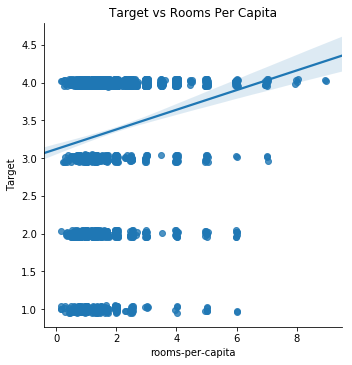

In [49]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

#### Correlation Heatmap 

One of my favorite plots is the correlation heatmap because it shows a ton of info in one image. For the heatmap, we'll pick 7 variables and show the correlations between themselves and with the target. 

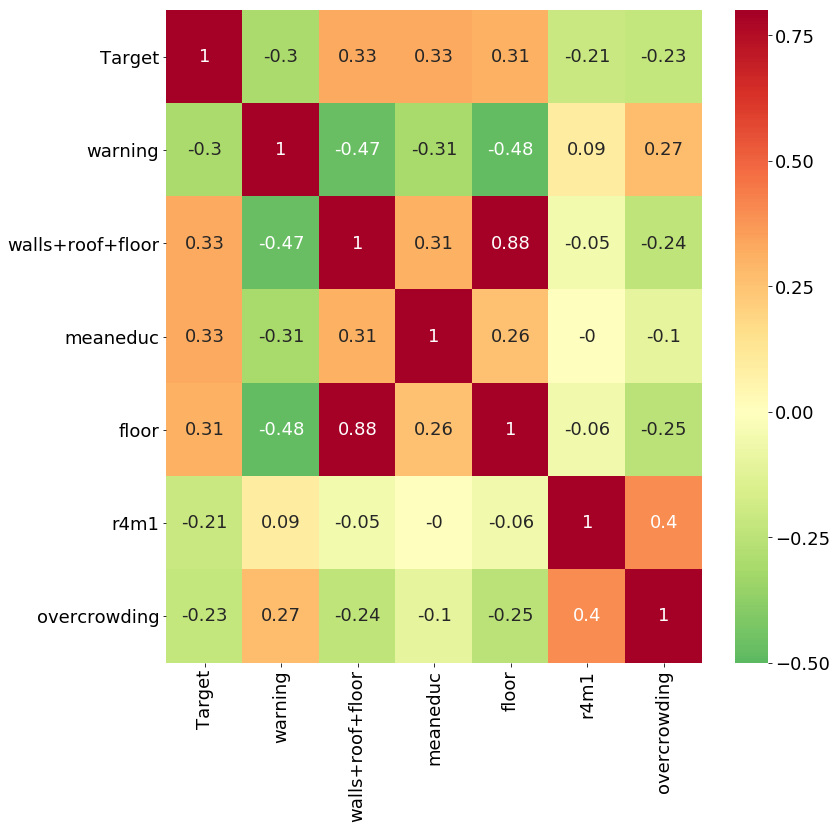

In [50]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

This plot shows us that there are a number of variables that have a weak correlation with the `Target`. There are also high correlations between some variables (such as `floor` and `walls+roof+floor`) which could pose an issue because of collinearity. 

### Features Plot

For the final exploration of the household level data, we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate (kde) plots on the diagonal, and 2D KDE plots on the lower triangle.

We'll leave the feature engineering of the household variables for now. Later, we can come back to this step if we are not pleased with the model performance.

In [51]:
household_feats = list(heads.columns)

# Individual Level Variables

There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering). 

In [52]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Redundant Individual Variables

We can do the same process we did with the household level variables to identify any redundant individual variables. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.

In [53]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

This is simply the opposite of male! We can remove the male flag.

In [54]:
ind = ind.drop(columns = 'male')

### Creating Ordinal Variables

Much as we did with the household level data, we can map existing columns to an ordinal variable. Here we will focus on the `instlevel_` variables which indicate the amount of education an individual has from `instlevel1`: no level of education to `instlevel9`: postgraduate education. 

To create the ordinal variable, for each individual, we will simply find which column is non-zero. The education has an inherent ordering (higher is better) so this conversion to an ordinal variable makes sense in the problem context.

In [55]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [56]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

Higher levels of education seem to correspond to less extreme levels of poverty. We do need to keep in mind this is on an individual level though and we eventually will have to aggregate this data at the household level. 

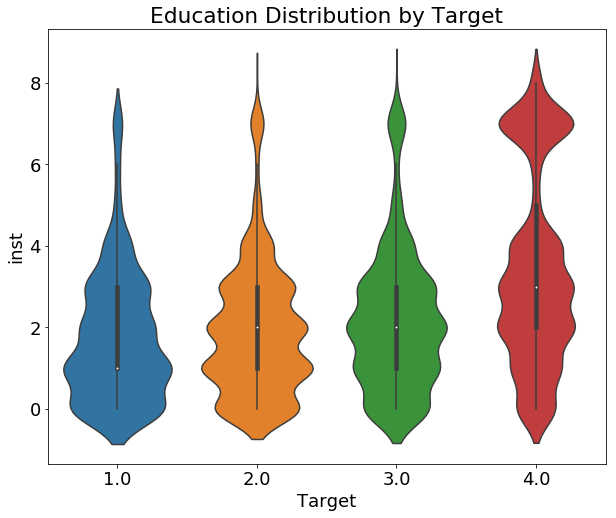

In [57]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

In [58]:
# Drop the education columns
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 40)

### Feature Construction

We can make a few features using the existing data. For example, we can divide the years of schooling by the age.

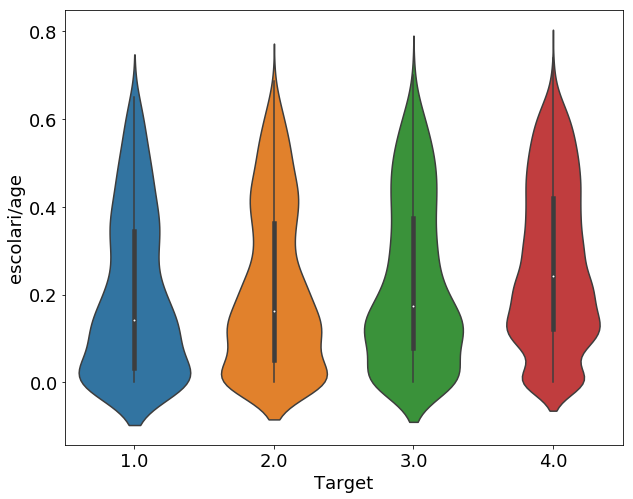

In [59]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

We can also take our new variable, `inst`, and divide this by the age. The final variable we'll name `tech`: this represents the combination of tablet and mobile phones.

In [60]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Feature Engineering through Aggregations

In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to `groupby` the family id `idhogar` and then `agg` the data. For the aggregations for ordered or continuous variables, we can use six, five of which are built in to pandas, and one of which we define ourselves `range_`. The boolean aggregations can be the same, but this will create many redundant columns which we will then need to drop. For this case, we'll use the same aggregations and then go back and drop the redundant columns.

In [61]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

With just that one line, we go from 30 features to 180. Next we can rename the columns to make it easier to keep track.

In [62]:
ind_agg

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
003514e22    1   1   4     4  0.0      0   0   0   0     4  0.000000      0   
003b51a87    0   0   0     4  0.0      0   0   1   1     4  0.500000      1   
003bf2fa9    0   0   0     1  NaN      0   0   0   0     1       NaN      0   
004417a6c    0   0   0     1  NaN      0   0   0   0     1       NaN      0   
0044a5929    0   0   0     1  NaN      0   0   0   0     1       NaN      0   
004616164    0   0   0     2  0.0      0   0   0   0     2  0.000000      0   
004983866    0   0   0     2  0.0      0   0   0   0     2  0.000000      0   
00498cd58    0   0   0     2  0.0      0   0   0   0     2  0.000000      0   
004ea2211    0   0   0     3  0.0      0   0   1   2     3  0.577350      1   
005411ee8    0   0   0     4  0.0      0   0   1   1     4  0.500000      1   
00564e3ca    0   0   0     5  0.0      0   0   0   0     5  0.000000      0   
005905417    0   0   0     3  0.0      0   0   0   0     3  0.000000      0   
006031de3    1   1   4     4  0.0      0   0   0   0     4  0.000000      0   
006555fe2    0   0   0     5  0.0      0   0   1   1     5  0.447214      1   
0065a3821    0   0   0     6  0.0      0   0   0   0     6  0.000000      0   
00693f597    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
006b64543    0   0   0     2  0.0      0   0   0   0     2  0.000000      0   
008222963    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
0082c4eb2    1   1   5     5  0.0      0   0   0   0     5  0.000000      0   
008c9c64a    0   0   0     3  0.0      0   0   0   0     3  0.000000      0   
008f48d3f    0   0   0     3  0.0      0   0   0   0     3  0.000000      0   
00941f1f4    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
0099bb7a8    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
009ae1cec    0   0   0     3  0.0      0   0   0   0     3  0.000000      0   
00a79c00f    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
...        ...  ..  ..   ...  ...    ...  ..  ..  ..   ...       ...    ...   
ff20bf256    0   0   0     5  0.0      0   0   0   0     5  0.000000      0   
ff250fd6c    0   0   0     4  0.0      0   0   1   2     4  0.577350      1   
ff307c73d    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
ff31b984b    1   1   3     3  0.0      0   0   1   1     3  0.577350      1   
ff38ddef1    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
ff4093d84    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
ff40eaa7f    0   0   0     3  0.0      0   0   0   0     3  0.000000      0   
ff46ad2bd    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
ff569c16d    1   1   4     4  0.0      0   0   0   0     4  0.000000      0   
ff69a6fc8    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
ff6d16fd0    0   0   0     2  0.0      0   0   0   0     2  0.000000      0   
ff703eed4    0   0   0     6  0.0      0   0   0   0     6  0.000000      0   
ff79f0143    0   0   0     8  0.0      0   0   0   0     8  0.000000      0   
ff7f210b5    0   0   0     1  NaN      0   0   0   0     1       NaN      0   
ff84f60e7    0   0   0     4  0.0      0   0   1   1     4  0.500000      1   
ff8eaf6cf    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
ff91e66fa    0   0   0     4  0.0      0   0   1   1     4  

In [63]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        lol = c  + "-" + stat 
        new_col.append(c+"-"+stat)
        
ind_agg.columns = new_col
ind_agg.head()

,"{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}",...,"{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}"
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4

In [64]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

,"{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}","{c} + ""-"" + {stat}"
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Feature Selection 

As a first round of feature selection, we can remove one out of every pair of variables with a correlation greater than 0.95. 

In [65]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print("There are", {len(to_drop)},  "correlated columns to remove.")

('There are', set([234]), 'correlated columns to remove.')


We'll drop the columns and then merge with the `heads` data to create a final dataframe.

In [66]:
to_drop

['{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {stat}',
 '{c}  + "-" + {

In [67]:
ind_agg = ind_agg.drop(to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = "idhogar", how = "left")

print("Final features shape: ", final.shape)

ValueError: labels ['{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'
 '{c}  + "-" + {stat}' '{c}  + "-" + {stat}' '{c}  + "-" + {stat}'] not contained in axis

In [ ]:
final.head()

### Final Data Exploration

We'll do a little bit of exploration. 

In [ ]:
corrs = final.corr()['Target']

In [ ]:
corrs.sort_values().head()

In [ ]:
corrs.sort_values().dropna().tail()

We can see some of the variables that we made are highly correlated with the Target. Whether these variables are actually _useful_ will be determined in the modeling stage. 

In [ ]:
plot_categoricals('escolari-max', 'Target', final, annotate=False);

In [ ]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target');

In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target');

One other feature that might be useful is the gender of the head of household. Since we aggregated the data, we'll have to go back to the individual level data and find the gender for the head of household.

In [ ]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [ ]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

It looks like households where the head is female are slightly more likely to have a severe level of poverty.

In [ ]:
sns.violinplot(x = 'female-head', y = 'Target', data = final);
plt.title('Target by Female Head of Household');

We can also look at the difference in average education by whether or not the family has a female head of household.

In [ ]:
plt.figure(figsize = (8, 8))
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'female-head', data = final);
plt.title('Average Education by Target and Female Head of Household', size = 16);

It looks like at every value of the `Target`, households with female heads have higher levels of education. Yet, we saw that overall, households with female heads are more likely to have severe poverty. 

In [ ]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

Overall, the average education of households with female heads is slightly higher than those with male heads. I'm not too sure what to make of this, but it seems right to me.